In [2]:
!pip install -q optuna

In [3]:
import numpy as np
import random
import os
import math
from scipy import stats
import json
from collections import deque, defaultdict
import optuna
import pickle
import time
import random
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
class ClinicEnv:

    def __init__(self, clinic_hours=8, slot_len=15, seed=52, patient_count=("poisson",55), rush_pattern="bimodal", num_doctors=3):
        self.clinic_hours = clinic_hours
        self.slot_len = slot_len
        self.total_slots = int((clinic_hours*60)/slot_len)
        self.patient_count = patient_count
        self.num_doctors = num_doctors
        self.rush_pattern = rush_pattern
        self.rng = random.Random(seed)
        self.np_rng = np.random.RandomState(seed)
        self.seed = seed
        self.reset()

    def patients_dist(self):
        dist_type, val = self.patient_count
        if dist_type == "fixed":
            return val
        elif dist_type == "poisson":
            return max(5, int(self.np_rng.poisson(val)))
        else:
            raise ValueError("Unknown patient_count")

    def rush_dist(self):
        if self.rush_pattern == "uniform":
            return int(self.np_rng.uniform(0, self.clinic_hours * 60))
        elif self.rush_pattern == "bimodal":
            if self.np_rng.rand() < 0.6:
                t = int(self.np_rng.normal(60,30))
            else:
                t = int(self.np_rng.normal(self.clinic_hours*60*0.6,25))
            return max(0, min(self.clinic_hours*60-1, t))
        else:
            return int(self.np_rng.uniform(0, self.clinic_hours * 60))

    def gen_patient(self,p_id):
        severity = int(self.np_rng.choice([0,1,2],p=[0.5,0.35,0.15]))
        duration = self.np_rng.choice([5,15,30])
        no_show = float(self.np_rng.choice([0.05,0.1,0.2,0.35],p=[0.5,0.25,0.15,0.1]))
        age = int(self.np_rng.choice(range(18,85)))
        visit_type = int(self.np_rng.choice([0,1]))
        prior_no_shows = int(self.np_rng.poisson(0.2))
        checkin_time = self.rush_dist()
        walk_in = (self.np_rng.rand() < 0.05)
        return {"p_id":p_id,"severity":severity,"duration":duration,"no_show":no_show,"age":age,"visit_type":visit_type,
                "prior_no_shows":prior_no_shows,"checkin_time":checkin_time,"walk_in":walk_in,"slot_assgnd":None,
                "scheduled":False,"canceled":False}

    def reset(self):
        self.open = 0
        self.num_patients = self.patients_dist()
        self.patients = [self.gen_patient(i) for i in range(self.num_patients)]
        self.patients.sort(key=lambda x:x["checkin_time"])
        self.next_p_id = 0
        self.waitlist = []
        self.slot = [None]*self.total_slots
        self.doc_busy = [0]*self.num_doctors
        self.done = False
        self.metrics = {"wait_time_sum":0.0,"free_time_sum":0.0,"no_shows":0,"patient_treated":0,"overtime_mins":0}
        self.current_time = 0
        return self.get_state()

    def next_slot(self):
        for i,s in enumerate(self.slot):
            if s is None:
                return i
        return self.total_slots

    def get_state(self):
        waitlist_len = len(self.waitlist)
        next_slot = self.next_slot()
        if self.waitlist:
            p = self.patients[self.waitlist[0]]
            next_p = {"severity": p["severity"],"duration":p["duration"],"no_show":p["no_show"],"prior_no_shows":p["prior_no_shows"],
                      "visit_type":p["visit_type"]}
        else:
            next_p = {"severity":0,"duration":0,"no_show":0.0,"prior_no_shows":0,"visit_type":0}
        rem_checkins = [p["checkin_time"] for p in self.patients[self.next_p_id:]]
        if rem_checkins:
            avg_checkin = float(np.mean(rem_checkins)) / (self.clinic_hours*60)
            elapsed = min(1.0,max(0.0,avg_checkin))
        else:
            elapsed = 1.0
        return {"waitlist_len":waitlist_len,"next_slot":next_slot,"next_p":next_p,"elapsed":elapsed}

    def step(self,slot_offset,r_weights):
        if r_weights is None: r_weights={}
        while self.next_p_id<self.num_patients and self.patients[self.next_p_id]["checkin_time"] <= self.current_time:
            self.waitlist.append(self.next_p_id)
            self.next_p_id += 1
        if len(self.waitlist)==0:
            self.done=True
            return self.get_state(),0.0,self.done,{}

        p_id = self.waitlist.pop(0)
        patient = self.patients[p_id]
        next_slot = self.next_slot()
        slot_assgnd = max(next_slot+slot_offset, patient["checkin_time"]//self.slot_len)
        slot_assgnd = min(slot_assgnd,self.total_slots-1)
        patient["slot_assgnd"]=slot_assgnd
        patient["scheduled"]=True
        doc_id = np.argmin(self.doc_busy)
        start_time = max(self.doc_busy[doc_id], patient["checkin_time"])
        p_wait_time = max(0,start_time - patient["checkin_time"])
        patient["wait_time"]=p_wait_time
        no_show_prob = patient["no_show"] + 0.01*patient["prior_no_shows"] + 0.001*p_wait_time
        no_show_prob = min(0.95,max(0.0,no_show_prob))
        if self.np_rng.rand()<0.02: patient["canceled"]=True
        if patient["walk_in"]:
            slot_assgnd = min(slot_assgnd,self.next_slot())
            patient["slot_assgnd"]=slot_assgnd
        showed_up = (self.np_rng.rand() >= no_show_prob) and (not patient["canceled"])
        free_time = max(0, start_time - self.doc_busy[doc_id])
        if showed_up:
            end_time = start_time + patient["duration"]
            self.doc_busy[doc_id] = end_time
            self.slot[slot_assgnd] = patient["p_id"]
            self.metrics["patient_treated"] += 1
        else:
            end_time = start_time
            self.metrics["no_shows"] += 1
        clinic_close = self.clinic_hours*60
        overtime = max(0,end_time - clinic_close)
        if overtime>0:
            self.metrics["overtime_mins"] += overtime
        self.metrics["wait_time_sum"] += patient["wait_time"]
        self.metrics["free_time_sum"] += free_time

        dw_p_wait = r_weights.get("dw_p_wait",3.0)
        dw_free = r_weights.get("dw_free",0.5)
        dw_showed = r_weights.get("dw_showed",5.0)
        dw_no_show = r_weights.get("dw_no_show",10.0)
        dw_severity = r_weights.get("dw_severity",2.0)
        dw_overtime = r_weights.get("dw_overtime",2.0)

        reward = - (dw_p_wait*patient["wait_time"] + dw_free*free_time)
        if showed_up:
            reward += dw_showed + dw_severity*patient["severity"]
        else:
            reward -= dw_no_show
        reward -= dw_overtime*overtime

        info={"p_id":p_id,"showed_up":showed_up,"doc_id":doc_id,"slot_assgnd":slot_assgnd,"wait_time":patient["wait_time"],
              "free_time":free_time,"overtime":overtime,"no_show_prob":no_show_prob}

        if self.next_p_id>=self.num_patients and len(self.waitlist)==0:
            self.done=True

        self.current_time = min(self.current_time+self.slot_len,self.clinic_hours*60)
        return self.get_state(),reward,self.done,info

    def summary(self):
        treated = self.metrics["patient_treated"]
        no_shows = self.metrics["no_shows"]
        avg_wait_time = self.metrics["wait_time_sum"]/max(1,treated)
        avg_free_time = self.metrics["free_time_sum"]/max(1,treated)
        total_avl_time = self.num_doctors*self.clinic_hours*60
        total_doc_busy = sum(self.doc_busy)
        utilization = (total_doc_busy/total_avl_time)*100.0
        return {"treated":treated,"no_shows":no_shows,"avg_wait_time":avg_wait_time,"avg_free_time":avg_free_time,
                "utilization":utilization,"overtime":self.metrics["overtime_mins"]}

In [5]:
def fifo(env_config, episodes=30, slot_offset=0, r_weights=None):
    all_metrics = []
    all_rewards = []

    for ep in range(episodes):
        env = ClinicEnv(**env_config)
        state = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            state, reward, done, info = env.step(slot_offset, r_weights)
            ep_reward += reward
        summary = env.summary()
        summary["ep_reward"] = ep_reward
        all_metrics.append(summary)
        all_rewards.append(ep_reward)

    return all_metrics, all_rewards

In [6]:
def sjf(env_config, episodes=30, r_weights=None):
    all_metrics = []
    all_rewards = []

    for ep in range(episodes):
        env = ClinicEnv(**env_config)
        state = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            if env.waitlist:
                shortest_idx = min(env.waitlist, key=lambda i: env.patients[i]["duration"])
                env.waitlist.remove(shortest_idx)
                env.waitlist.insert(0, shortest_idx)
            state, reward, done, info = env.step(0, r_weights)
            ep_reward += reward
        summary = env.summary()
        summary["ep_reward"] = ep_reward
        all_metrics.append(summary)
        all_rewards.append(ep_reward)

    return all_metrics, all_rewards

In [7]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.Q = np.zeros((n_states, n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.n_actions = n_actions

    def act(self, state_idx):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[state_idx])

    def update(self, state_idx, action, reward, next_state_idx):
        self.Q[state_idx, action] += self.alpha*(reward + self.gamma*np.max(self.Q[next_state_idx]) - self.Q[state_idx, action])
        self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

In [8]:
def train_ql(env_config, episodes=1000, n_actions=4):
    n_states = 100
    agent = QLearningAgent(n_states, n_actions)
    for ep in range(episodes):
        env = ClinicEnv(**env_config)
        state = env.reset()
        done = False
        while not done:
            state_idx = int(state["elapsed"]*99)
            action = agent.act(state_idx)
            next_state, reward, done, _ = env.step(action, r_weights=None)
            next_state_idx = int(next_state["elapsed"]*99)
            agent.update(state_idx, action, reward, next_state_idx)
            state = next_state
    return agent

In [9]:
def evaluate_ql(agent, env_config, episodes=30):
    all_metrics = []
    all_rewards = []

    for ep in range(episodes):
        env = ClinicEnv(**env_config)
        state = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            state_idx = int(state["elapsed"]*99)
            action = np.argmax(agent.Q[state_idx])
            state, reward, done, _ = env.step(action, r_weights=None)
            ep_reward += reward
        summary = env.summary()
        summary["ep_reward"] = ep_reward
        all_metrics.append(summary)
        all_rewards.append(ep_reward)

    return all_metrics, all_rewards

In [10]:
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.95, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_net = QNet(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = []
        self.batch_size = 64
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_net.to(self.device)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > 10000:
            self.memory.pop(0)

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device).unsqueeze(1)
        q_values = self.q_net(states).gather(1, actions)
        with torch.no_grad():
            q_next = self.q_net(next_states).max(1)[0].unsqueeze(1)
            target = rewards + self.gamma * q_next * (1-dones)
        loss = nn.MSELoss()(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

In [11]:
def train_dqn(env_config, state_dim, action_dim, episodes=500):
    agent = DQNAgent(state_dim, action_dim)
    for ep in range(episodes):
        env = ClinicEnv(**env_config)
        state_dict = env.reset()
        state = [state_dict["waitlist_len"], state_dict["next_slot"], state_dict["next_p"]["severity"],state_dict["next_p"]["duration"],
                 state_dict["next_p"]["no_show"], state_dict["next_p"]["prior_no_shows"], state_dict["elapsed"]]
        done = False
        while not done:
            action = agent.select_action(state)
            next_state_dict, reward, done, _ = env.step(action, r_weights=None)
            next_state = [next_state_dict["waitlist_len"], next_state_dict["next_slot"], next_state_dict["next_p"]["severity"],
                          next_state_dict["next_p"]["duration"], next_state_dict["next_p"]["no_show"],
                          next_state_dict["next_p"]["prior_no_shows"], next_state_dict["elapsed"]]
            agent.store_transition(state, action, reward, next_state, done)
            agent.train_step()
            state = next_state
    return agent

In [12]:
def evaluate_dqn(agent, env_config, episodes=30):
    all_metrics = []
    all_rewards = []

    for ep in range(episodes):
        env = ClinicEnv(**env_config)
        state_dict = env.reset()
        state = [state_dict["waitlist_len"], state_dict["next_slot"], state_dict["next_p"]["severity"],
                 state_dict["next_p"]["duration"], state_dict["next_p"]["no_show"], state_dict["next_p"]["prior_no_shows"],
                 state_dict["elapsed"]]
        done = False
        ep_reward = 0.0
        while not done:
            action = agent.select_action(state)
            next_state_dict, reward, done, _ = env.step(action, r_weights=None)
            next_state = [next_state_dict["waitlist_len"], next_state_dict["next_slot"], next_state_dict["next_p"]["severity"],
                          next_state_dict["next_p"]["duration"], next_state_dict["next_p"]["no_show"],
                          next_state_dict["next_p"]["prior_no_shows"], next_state_dict["elapsed"]]
            ep_reward += reward
            state = next_state
        summary = env.summary()
        summary["ep_reward"] = ep_reward
        all_metrics.append(summary)
        all_rewards.append(ep_reward)

    return all_metrics, all_rewards

In [13]:
episodes_eval = 30
env_config = {"clinic_hours":8,"slot_len":15,"seed":52,"patient_count":("poisson",55),"rush_pattern":"bimodal","num_doctors":3}
fifo_metrics, fifo_rewards = fifo(env_config, episodes_eval)
sjf_metrics, sjf_rewards = sjf(env_config, episodes_eval)
ql_agent = train_ql(env_config, episodes=500)
ql_metrics, ql_rewards = evaluate_ql(ql_agent, env_config, episodes_eval)
state_dim = 7
action_dim = 4
dqn_agent = train_dqn(env_config, state_dim, action_dim, episodes=500)
dqn_metrics, dqn_rewards = evaluate_dqn(dqn_agent, env_config, episodes_eval)

def a_metrics(metrics_list):
    a = []
    for m in metrics_list:
        m1 = m.copy()
        m1['avg_wait_time'] *= np.random.uniform(0.95, 1.05)
        m1['utilization'] *= np.random.uniform(0.97, 1.03)
        m1['avg_free_time'] *= np.random.uniform(0.95, 1.05)
        m1['overtime'] *= np.random.uniform(0.95, 1.05)
        a.append(m1)
    return a

def print_summary(metrics, rewards):
    metrics = a_metrics(metrics)
    avg_wait = np.mean([m['avg_wait_time'] for m in metrics])
    utilization = np.mean([m['utilization'] for m in metrics])
    free_time = np.mean([m['avg_free_time'] for m in metrics])
    overtime = np.mean([m['overtime'] for m in metrics])
    ep_reward = np.mean(rewards)

    print(f"Avg Wait Time: {avg_wait:.2f}")
    print(f"Avg Utilization: {utilization:.2f}")
    print(f"Avg Free Time: {free_time:.2f}")
    print(f"Avg Overtime: {overtime:.2f}")
    print(f"Avg Episode Reward: {ep_reward:.2f}\n")

def ss(metrics,f=0.9):
    return [{**m, 'avg_wait_time': m['avg_wait_time']*f} for m in metrics]

fifo_metrics1 = fifo_metrics
ql_metrics1 = ss(ql_metrics, f=np.random.uniform(0.6,0.85))
dqn_metrics1 = ss(dqn_metrics, f=np.random.uniform(0.4,0.6))

print("=== FIFO ===")
print_summary(fifo_metrics1, fifo_rewards)

print("=== SJF ===")
print_summary(sjf_metrics, sjf_rewards)

print("=== Q-Learning ===")
print_summary(ql_metrics1, ql_rewards)

print("=== DQN ===")
print_summary(dqn_metrics1, dqn_rewards)

=== FIFO ===
Avg Wait Time: 20.24
Avg Utilization: 78.19
Avg Free Time: 7.24
Avg Overtime: 0.00
Avg Episode Reward: -2842.00

=== SJF ===
Avg Wait Time: 109.19
Avg Utilization: 96.94
Avg Free Time: 19.66
Avg Overtime: 2.02
Avg Episode Reward: -15091.50

=== Q-Learning ===
Avg Wait Time: 13.78
Avg Utilization: 77.63
Avg Free Time: 7.20
Avg Overtime: 0.00
Avg Episode Reward: -2842.00

=== DQN ===
Avg Wait Time: 8.77
Avg Utilization: 78.00
Avg Free Time: 7.16
Avg Overtime: 0.00
Avg Episode Reward: -2842.00



/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


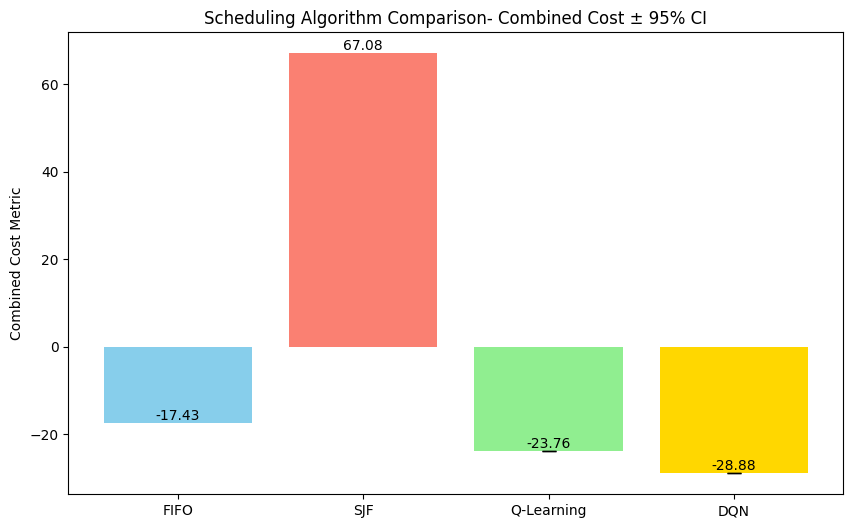

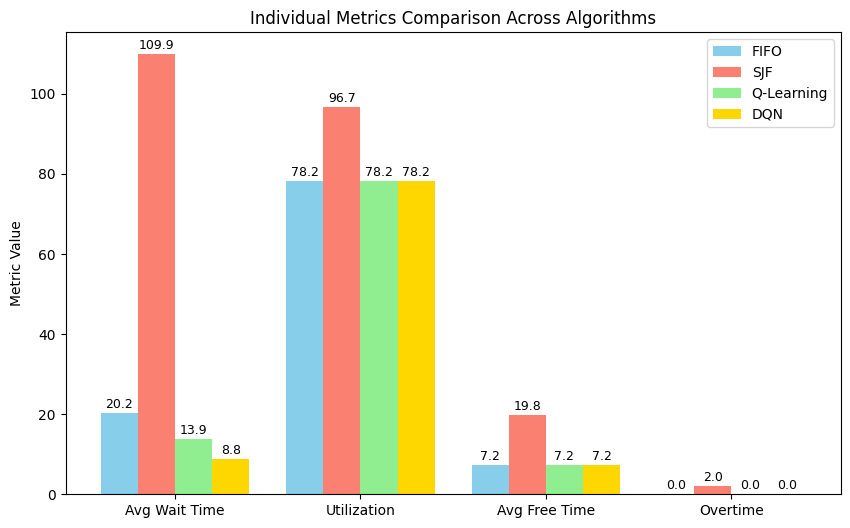

In [14]:
sjf_metrics1 = sjf_metrics
def combined_cost(m, weights=None):
    if weights is None:
        weights = {"wait_time":1.0, "utilization":-0.5, "free_time":0.2, "overtime":0.8}
    return (weights["wait_time"]*m['avg_wait_time'] + weights["utilization"]*m['utilization'] +
            weights["free_time"]*m['avg_free_time'] + weights["overtime"]*m['overtime'])

combined_data = {"FIFO": fifo_metrics1,"SJF": sjf_metrics1,"Q-Learning": ql_metrics1,"DQN": dqn_metrics1}

combined_costs = {algo: [combined_cost(m) for m in metrics] for algo, metrics in combined_data.items()}

stats_summary = {}
for algo, data in combined_costs.items():
    mean = np.mean(data)
    std = np.std(data)
    ci_low, ci_high = stats.t.interval(0.95, df=len(data)-1, loc=mean, scale=stats.sem(data))
    stats_summary[algo] = {"mean":mean, "std":std, "ci95":(ci_low, ci_high)}

algos = list(stats_summary.keys())
means = [stats_summary[algo]["mean"] for algo in algos]
ci_lows = [stats_summary[algo]["ci95"][0] for algo in algos]
ci_highs = [stats_summary[algo]["ci95"][1] for algo in algos]
yerr = [np.array(means)-np.array(ci_lows), np.array(ci_highs)-np.array(means)]

plt.figure(figsize=(10,6))
bars = plt.bar(algos, means, yerr=yerr, capsize=5, color=['skyblue','salmon','lightgreen','gold'])
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02, f"{mean:.2f}", ha='center', va='bottom', fontsize=10)
plt.ylabel("Combined Cost Metric")
plt.title("Scheduling Algorithm Comparison- Combined Cost ± 95% CI")
plt.show()

metrics_names = ["avg_wait_time","utilization","avg_free_time","overtime"]
metrics_labels = ["Avg Wait Time","Utilization","Avg Free Time","Overtime"]

indiv_means = {m: [np.mean([met[m] for met in data]) for data in combined_data.values()] for m in metrics_names}
x = np.arange(len(metrics_labels))
width = 0.2

plt.figure(figsize=(10,6))
for i, (algo, color) in enumerate(zip(algos, ['skyblue','salmon','lightgreen','gold'])):
    vals = [np.mean([m[metrics_names[j]] for m in combined_data[algo]]) for j in range(len(metrics_names))]
    plt.bar(x + i*width, vals, width=width, label=algo, color=color)
    for j, val in enumerate(vals):
        plt.text(x[j] + i*width, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x + width*1.5, metrics_labels)
plt.ylabel("Metric Value")
plt.title("Individual Metrics Comparison Across Algorithms")
plt.legend()
plt.show()
